# PVGeo-Discretize

This notebook demonstrates how to pair `PVGeo` and `discretize` for simple processing routines. 

This notebook is outlined into four sections:

1. Introduction to PVGeo
2. Overview of new VTK interface in `discretize`
3. Pairing PVGeo and `discretize`
4. Examples of PVGeo in ParaView

In [1]:
%matplotlib notebook
import discretize
import PVGeo
import numpy as np
import vtki
import vtk

print('NumPy Version: %s' % np.__version__)
print('PVGeo Version: %s' % PVGeo.__version__)
print('vtki Version: %s' % vtki.__version__)
print('vtk Version: %s' % vtk.VTK_VERSION)

vtki.set_plot_theme('document')

NumPy Version: 1.16.2
PVGeo Version: 1.2.2
vtki Version: 0.17.5
vtk Version: 8.1.2


## 1. Learn about PVGeo

To learn more about PVGeo, please refer to the first notebook: `1.0 - Welcome`

## 2. Discretize VTK Mixin

This section demonstrates the VTK interface in `discretize` outlined in [SimPEG/discretize#114](https://github.com/simpeg/discretize/pull/114).

Let's check out how the new VTK interface can be used on simple mesh objects to create a VTK data object ready for VTK and/or PVGeo processing routines.

<IPython.core.display.Javascript object>


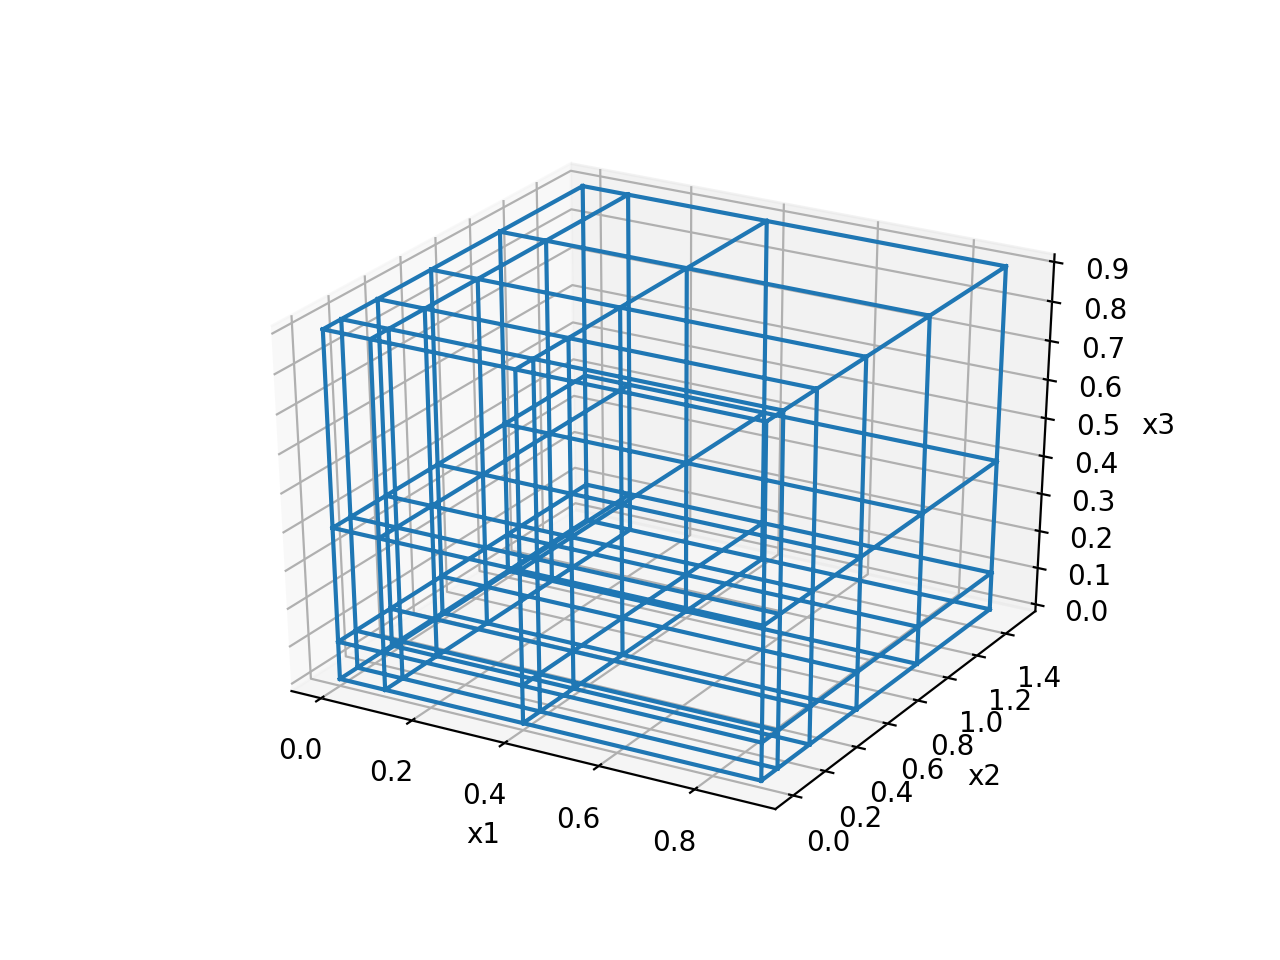

In [2]:
# Create a simple TensorMesh
h1 = np.linspace(.1, .5, 3)
h2 = np.linspace(.1, .5, 5)
h3 = np.linspace(.1, .5, 3)
mesh = discretize.TensorMesh([h1, h2, h3])
mesh.plotGrid()

Now that we have a `TensorMesh` object, we can call the `toVTK()` method to yield the proper VTK data object.

In [3]:
# Get a VTK data object
grid = mesh.toVTK()
grid

RectilinearGrid,Information
N Cells,45
N Points,96
X Bounds,"0.000e+00, 9.000e-01"
Y Bounds,"0.000e+00, 1.500e+00"
Z Bounds,"0.000e+00, 9.000e-01"
Volume,1.215e+00
N Scalars,0


An additional feature added in [SimPEG/discretize#114](https://github.com/simpeg/discretize/pull/114) is the ability to specify rotated reference frames for any given mesh object. Let's rotate our reference frame and then convert the mesh to a VTK data object. Note that we no longer have a `vtkRectilinearGrid` but a `vtkStructuredGrid` due to having that `TensorMesh` rotated off of the traditional reference frame (traditional being <1,0,0>, <0,1,0>, <0,0,1>).

In [4]:
# Defined a rotated reference frame
mesh.axis_u = (1,-1,0)
mesh.axis_v = (-1,-1,0)
mesh.axis_w = (0,0,1)

# Check that the referenc fram is valid
mesh._validate_orientation()

# At this time, the grid code in discretize is not updated to plot the rotated grid

True

In [5]:
# Yield the rotated vtkStructuredGrid
grid_r = mesh.toVTK()
grid_r

StructuredGrid,Information
N Cells,45
N Points,96
X Bounds,"-1.061e+00, 6.364e-01"
Y Bounds,"-1.697e+00, 0.000e+00"
Z Bounds,"0.000e+00, 9.000e-01"
Volume,1.215e+00
N Scalars,0


Here is a rendering of these two meshes to demonstrate the rotation:

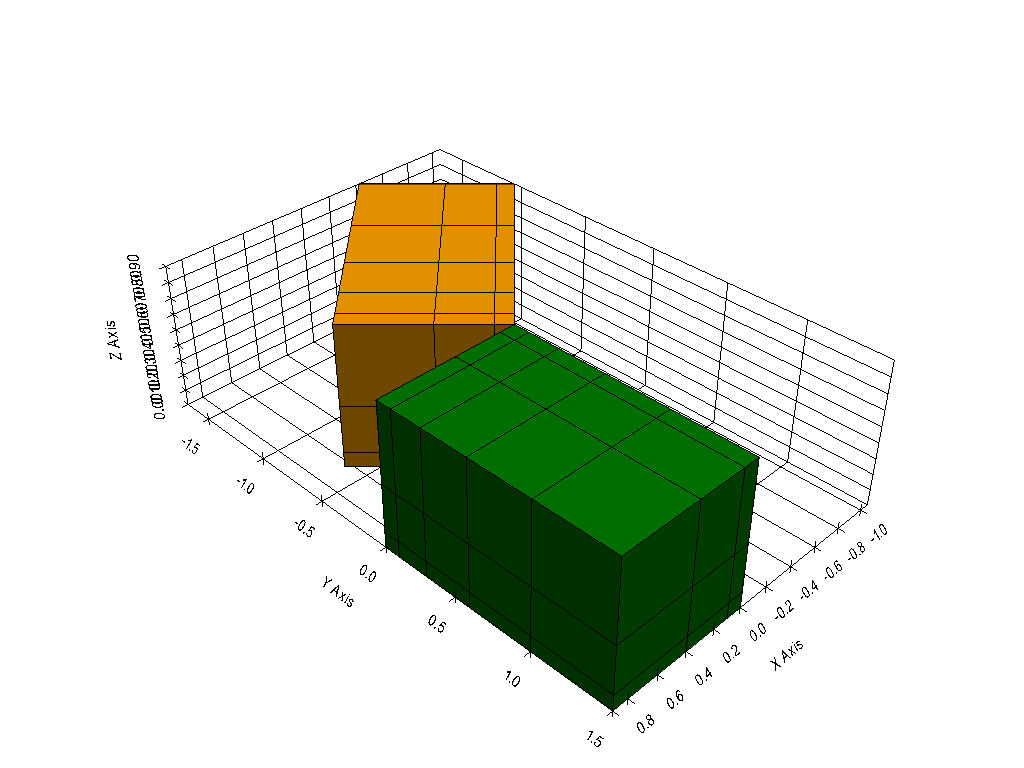

In [6]:
# Note: you could also use vtki.BackgroundPlotter() for interactivity
p = vtki.Plotter(notebook=True)
p.add_mesh(grid, color='green', show_edges=True)
p.add_mesh(grid_r, color='orange', show_edges=True)
p.show_grid()
p.show()

## 3. Pairing discretize+PVGeo

In this example, we load a `discretize` 3D model and a topography surface that generally covers that model in space. We then use PVGeo to provide a boolean array to describe whether any given cell is above/below the topography surface for the mesh.

This is a fairly simple example... we want you to focus less on the specific task of extracting the topography and more on the idea that `discretize` and `PVGeo` are able to talk to eachother and share their processing results.

### The Data

Here we load in some data we'd like to process: the [**Laguna del Maule Bouguer Gravity**](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example from the SimPEG docs.

This data scene is was produced from the [Laguna del Maule Bouguer Gravity](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example provided by [Craig Miller](https://github.com/craigmillernz) (Maule volcanic field, Chile. Refer to Miller et al 2016 EPSL for full details.)

> Miller, C. A., Williams-Jones, G., Fournier, D., & Witter, J. (2017). 3D gravity inversion and thermodynamic modelling reveal properties of shallow silicic magma reservoir beneath Laguna del Maule, Chile. Earth and Planetary Science Letters, 459, 14–27. https://doi.org/10.1016/j.epsl.2016.11.007

The rendering below shows several data sets and a model integrated together:

* Point Data: the Bouguer gravity anomalies
* Topography Surface
* Inverted Model: The model has been both sliced and thresholded for low values


This rendering was created in ParaView using file I/O methods in PVGeo for UBC fomrats and general VTK filters available in ParaView. A ParaView state file is included in the data directory to recreate this scene.

![scene](./images/craig-example.png)

In [7]:
#!head data/Craig-Chile/LdM_topo.topo

In [8]:
#!head data/Craig-Chile/craig_chile.msh

Let's load the data files using a mixture of `discretize` and `PVGeo` for now to demo how PVGeo and discretize can talk to eachother.

<IPython.core.display.Javascript object>


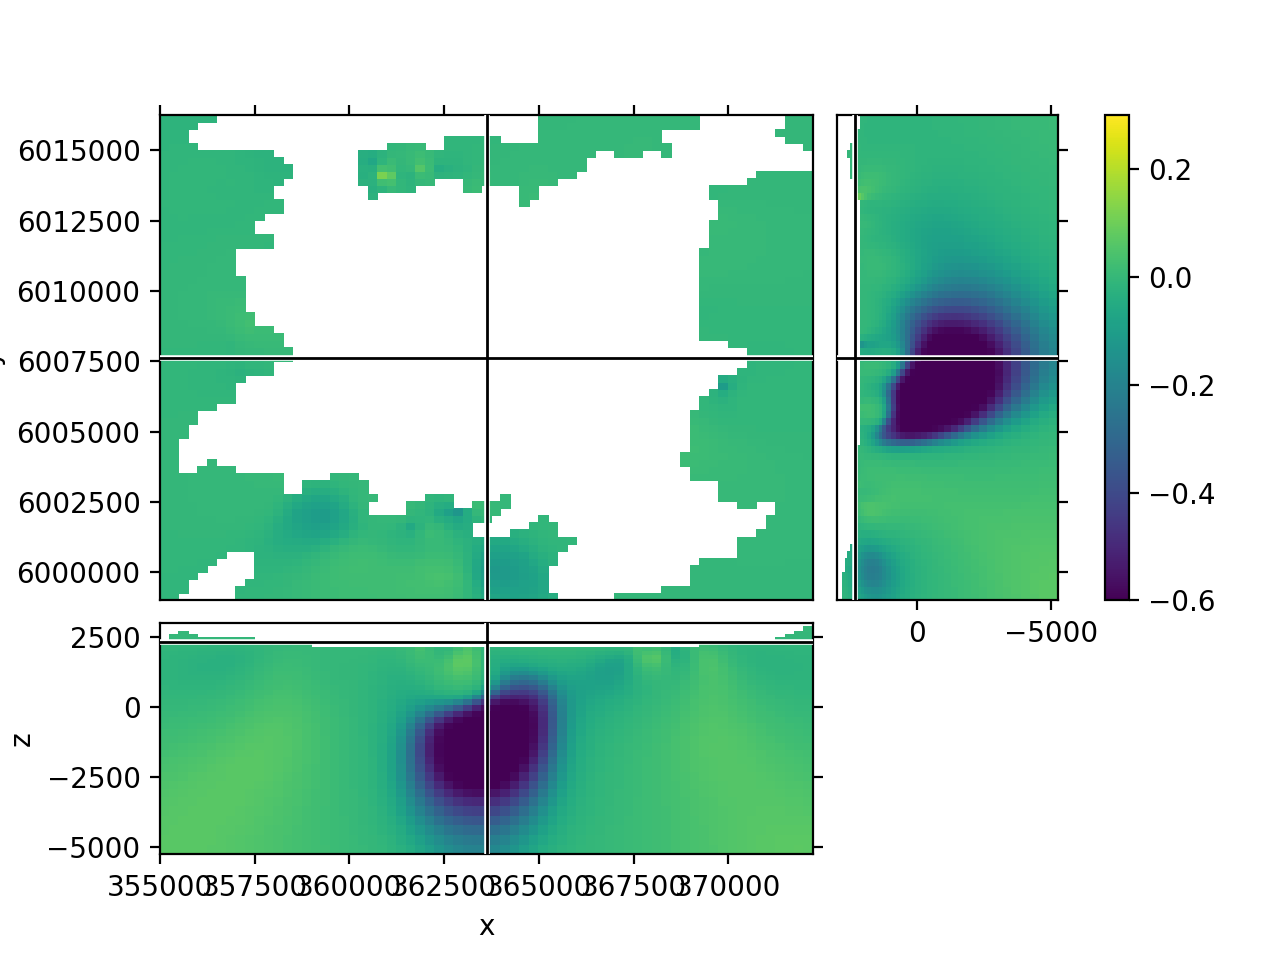

In [9]:
# Load the TensorMesh and some already processed model data 
mesh = discretize.TensorMesh.readUBC('craig_chile.msh', directory='data/Craig-Chile')
models = {'lpout': mesh.readModelUBC(fileName='Lpout.mod', directory='data/Craig-Chile')}
mesh.plot_3d_slicer(v=models['lpout'], zslice=2350)

In [10]:
mesh.nC

190440

### Process the Data

Now let's use the mesh from `discretize` and the topo surface in `PVGeo` to create a model array that describes whether or not any given cell in the model space is above/below the topogrpahy surface.

Also, let's ignore the fact the given model data is already accounts for topography (NaN values). Let's suppose for a moment that you are designing/inspecting your model space: Simply load the topography into a `vtkPolyData` object in `PVGeo` and feed it to the `ExtractTopography` algorithm.

Since the given topography file is in the [3D GIF Topography](https://giftoolscookbook.readthedocs.io/en/latest/content/fileFormats/topoGIF3Dfile.html) format, we can use the `PVGeo.ubc.TopoReader` file reader to read the file and automatically construct the `vtkPolyData`

In [11]:
# Load topography data using PVGeo
topo = PVGeo.ubc.TopoReader().Apply('data/Craig-Chile/LdM_topo.topo')
topo

PolyData (0xb2e3dadc8)
  N Cells:	381924
  N Points:	381924
  X Bounds:	3.550e+05, 3.720e+05
  Y Bounds:	5.999e+06, 6.016e+06
  Z Bounds:	2.050e+03, 3.104e+03
  Volume:	0.000e+00
  N Scalars:	1

In [12]:
# Call the ExtractTopography algorithm and have it apply on the 
#    discretize mesh and the topography
extracted = PVGeo.grids.ExtractTopography().Apply(mesh.toVTK(models), topo)
extracted

RectilinearGrid (0xb3297fd68)
  N Cells:	190440
  N Points:	200900
  X Bounds:	3.550e+05, 3.722e+05
  Y Bounds:	5.999e+06, 6.016e+06
  Z Bounds:	-5.250e+03, 3.000e+03
  Volume:	2.455e+12
  N Scalars:	2

In [13]:
active = extracted.get_scalar('Extracted')

In [14]:
models['active'] = active

In [15]:
mesh.plot_3d_slicer(v=models['active'], zslice=2350)

<IPython.core.display.Javascript object>

What about plotting those orthographic slices in 3D and showing the topography and creating a whole integrated scene?

In [16]:
slices = extracted.slice_orthogonal()

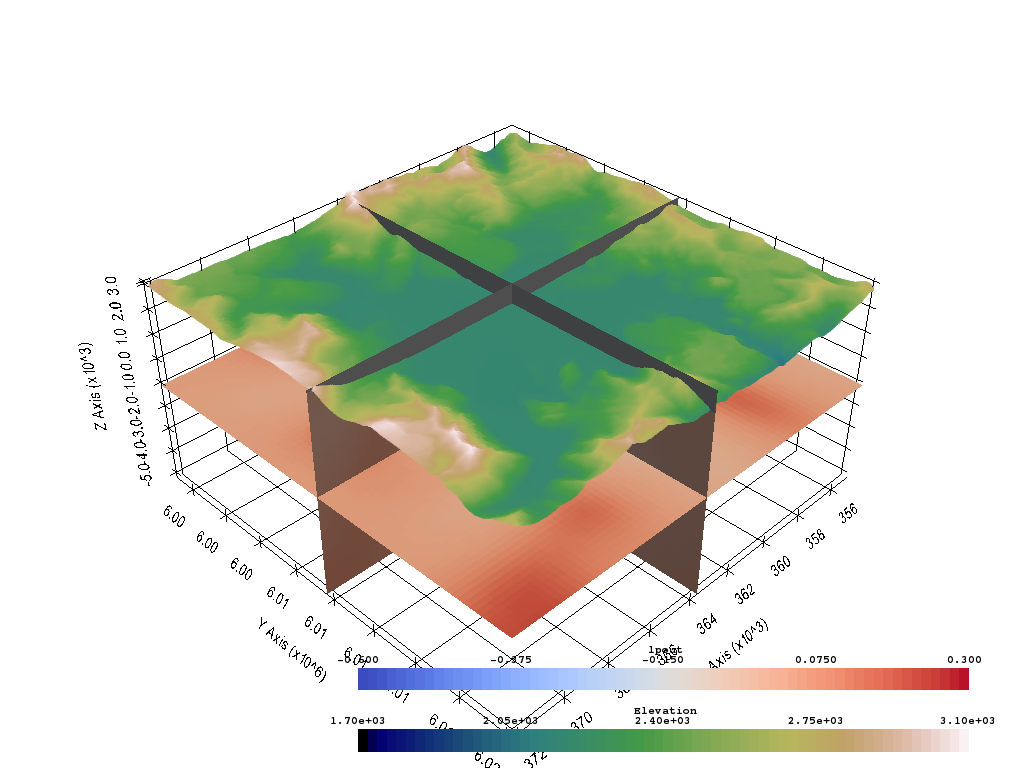

In [17]:
# And then we can add more features to the scene
p = vtki.Plotter()
p.add_mesh(topo, opacity=0.5, psize=1.0, 
           cmap='gist_earth', clim=[1.7e+03, 3.104e+03])
p.add_mesh(slices, cmap='coolwarm')
p.show_grid()
p.show()

### What about using a VTK algorthm?

Easy! Simply pass the VTK object to the VTK algorithm and use PVGeo's top level functions to yield the output in NumPy or Pandas friendly data structures!

In [18]:
# Instantiate your algorithm
alg = vtk.vtkCellSizeFilter()
# Set the inputs
alg.SetInputDataObject(mesh.toVTK(models=models))
# Run the algorithm
alg.Update()
# Yield the output on the 0th port
out = alg.GetOutputDataObject(0)

# Get the Volme array via PVGeo
counts = PVGeo.getArray(out, 'Volume')
# Use that arry to plot up the results!
mesh.plot_3d_slicer(counts)

<IPython.core.display.Javascript object>

Or better yet, utilize `vtki`'s streamlined interface to VTK:

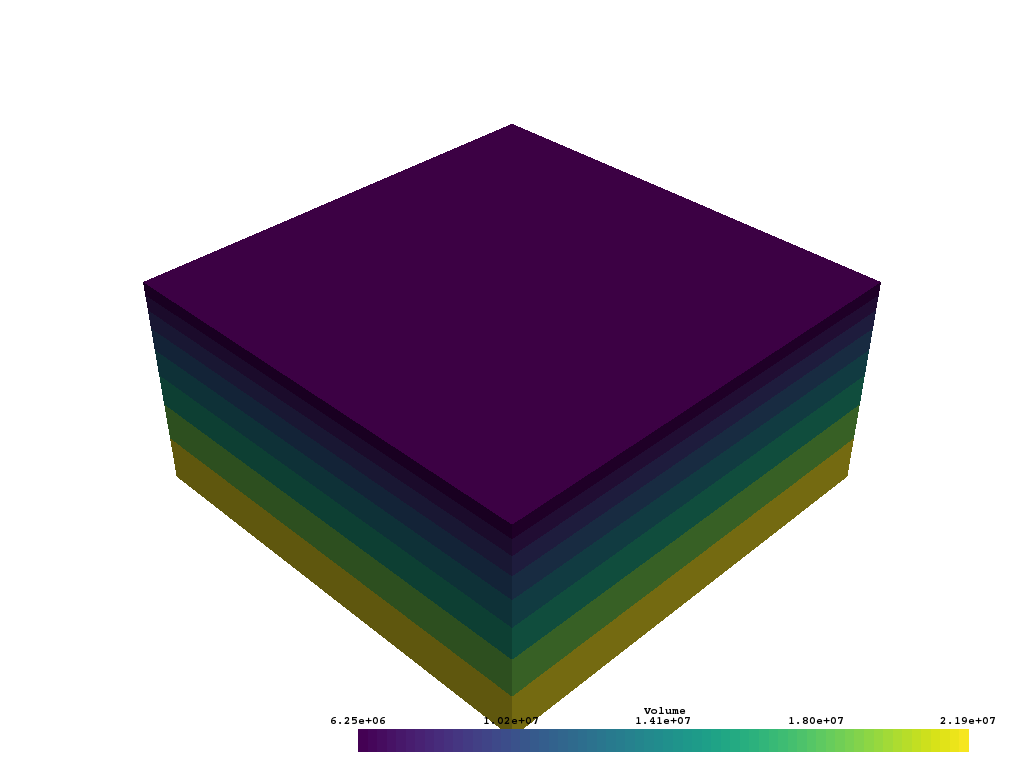

In [19]:
cell_sizes = mesh.toVTK(models=models).compute_cell_sizes()
cell_sizes.plot(scalars='Volume')

## 4. Now What?

There are tons of awesome algorithms in ParaView/VTK and PVGeo that you could use to integrate datasets and produce meaningful visualizations. At this time, using those algorithms in a standard Python environment doesn't really make sense... They should be used directly in ParaView or `pvpython` to create visualizations until we have a stable toolset for interactive VTK visualizations in Jupyter Notebooks.

Note that the new VTK interface in `discretize` enables PVGeo to build an interface for `discretize` directly in [ParaView](https://paraview.org).

Use the UBC suite in PVGeo which has I/O functionality for `discretize` to create compelling 3D visualizations of all your data!

Some algorithms that might be of interest to you:

- [Extract Topography](http://pvgeo.org/examples/grids/extract-topography/): Use a topography surface to add an active cells field to an input dataset
- [Create Rectilinear Grid](http://pvgeo.org/examples/model-building/create-rectilinear-grid/) : Create a rectilinear grid / tensor mesh (`vtkRectilinearGrid`)
- [The UBC suite in PVGeo](http://pvgeo.org/examples/contents/#ubc-mesh-tools): Contains file I/O for TensorMeshes, TreeMeshes, and time series model data as well as file readers for general data formats like Grav/Mag observations or topography surfaces. The status of the UBC suite can be found on [OpenGeoVis/PVGeo#28](https://github.com/OpenGeoVis/PVGeo/issues/28).
- [Many Slices Along Axis](http://pvgeo.org/examples/filters-general/many-slices-along-axis/): Generate N slices of a dataset along a specified axis


